In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from collections import Counter
import imblearn
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("cancer_cervical.csv")


In [3]:
df.tail(5)

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
963,34,3,18,0,0,0,0,0,0,0,...,?,?,0,0,0,0,0,0,0,0
964,32,2,19,1,0,0,0,1,8,0,...,?,?,0,0,0,0,0,0,0,0
965,25,2,17,0,0,0,0,1,0.08,0,...,?,?,0,0,0,0,0,0,1,0
966,33,2,24,2,0,0,0,1,0.08,0,...,?,?,0,0,0,0,0,0,0,0
967,29,2,20,1,0,0,0,1,0.5,0,...,?,?,0,0,0,0,0,0,0,0


In [4]:
df=df.replace('?',np.NaN)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968 entries, 0 to 967
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Age                                 968 non-null    int64 
 1   Number of sexual partners           939 non-null    object
 2   First sexual intercourse            958 non-null    object
 3   Num of pregnancies                  898 non-null    object
 4   Smokes                              952 non-null    object
 5   Smokes (years)                      952 non-null    object
 6   Smokes (packs/year)                 952 non-null    object
 7   Hormonal Contraceptives             846 non-null    object
 8   Hormonal Contraceptives (years)     846 non-null    object
 9   IUD                                 835 non-null    object
 10  IUD (years)                         835 non-null    object
 11  STDs                                846 non-null    object

# Data Preprocessing

In [6]:
df.columns=['Age', 'No_of_sex_partner', 'First_sexual_intercourse','No_pregnancies','Smokes',  'Smokes_yrs',  'Smokes_packs_yr',  'Hormonal_Contraceptives', 'Hormonal_Contraceptives_years','IUD', 'IUD_years', 'STDs', 'STDs_number', 'STDs_condylomatosis','STDs_cervical_condylomatosis', 'STDs_vaginal_condylomatosis', 'STDs_vulvo_perineal_condylomatosis','STDs_syphilis', 'STDs_pelvic_inflammatory_disease', 'STDs_genital_herpes', 'STDs_molluscum_contagiosum','STDs_AIDS', 'STDs_HIV', 'STDs_Hepatitis_B', 'STDs_HPV', 'STDs_No_of_diagnosis', 'STD_Time_since_first_diagnosis','STDs_Time_since_last_diagnosis', 'Dx_Cancer', 'Dx_CIN', 'Dx_HPV', 'Dx', 'Hinselmann','Schiller' ,'Citology', 'Biopsy']


<AxesSubplot:>

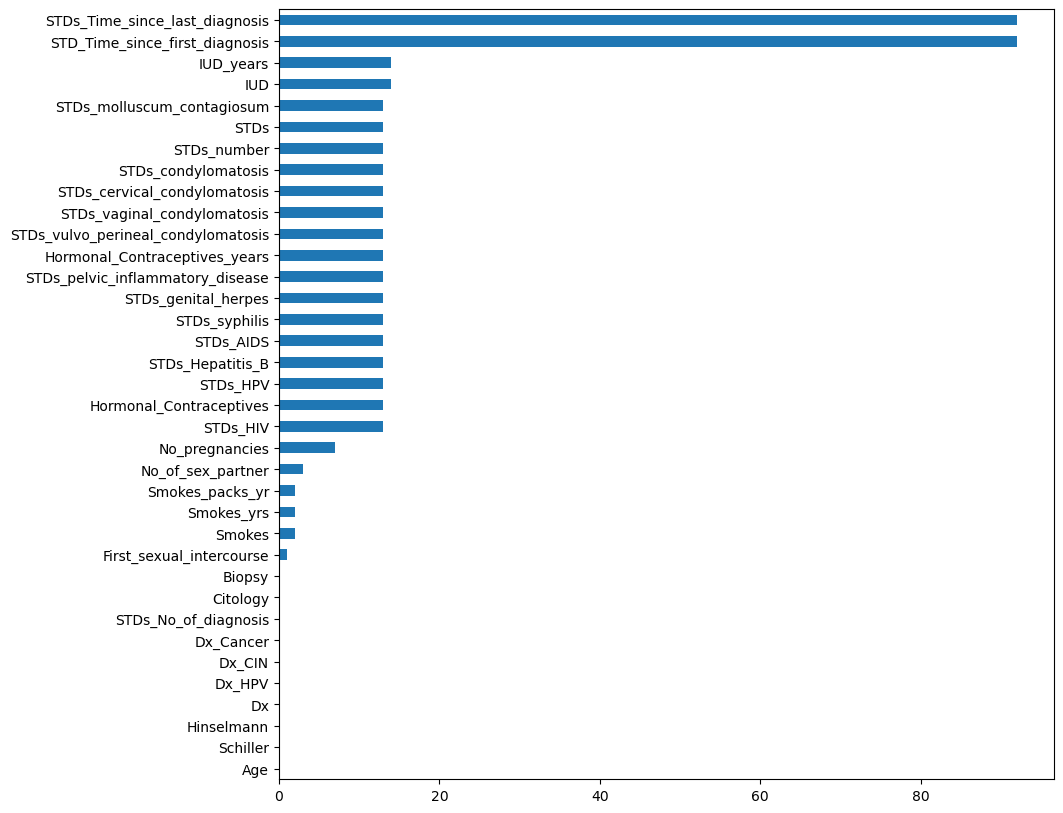

In [7]:
##checking percentage of missing values 
plt.figure(figsize=(10,10))
np.round(df.isnull().sum()/df.shape[0]*100).sort_values().plot(kind='barh')

In [8]:
##smoke and first sexual intercose has very little null values
##first and last time diagnosis of STD's has more than 80% null values
# hence drop the values
df=df.drop(['STD_Time_since_first_diagnosis','STDs_Time_since_last_diagnosis'],axis=1)
df=df.drop(df.index[df.Smokes.isnull()] | df.index[df.First_sexual_intercourse.isnull()])



In [9]:
x_features=list(df.columns)
x_features.remove('Biopsy')

In [10]:
x_features_categorical=[
 'Smokes','Hormonal_Contraceptives','IUD','STDs','STDs_condylomatosis','STDs_cervical_condylomatosis','STDs_vaginal_condylomatosis','STDs_vulvo_perineal_condylomatosis','STDs_syphilis','STDs_pelvic_inflammatory_disease','STDs_genital_herpes','STDs_molluscum_contagiosum','STDs_AIDS','STDs_HIV','STDs_Hepatitis_B','STDs_HPV','Dx_Cancer','Dx_CIN','Dx_HPV','Dx']
x_features_categorical

['Smokes',
 'Hormonal_Contraceptives',
 'IUD',
 'STDs',
 'STDs_condylomatosis',
 'STDs_cervical_condylomatosis',
 'STDs_vaginal_condylomatosis',
 'STDs_vulvo_perineal_condylomatosis',
 'STDs_syphilis',
 'STDs_pelvic_inflammatory_disease',
 'STDs_genital_herpes',
 'STDs_molluscum_contagiosum',
 'STDs_AIDS',
 'STDs_HIV',
 'STDs_Hepatitis_B',
 'STDs_HPV',
 'Dx_Cancer',
 'Dx_CIN',
 'Dx_HPV',
 'Dx']

In [11]:
x_features_numerical=[i for i in x_features if i not in x_features_categorical]
x_features_numerical


['Age',
 'No_of_sex_partner',
 'First_sexual_intercourse',
 'No_pregnancies',
 'Smokes_yrs',
 'Smokes_packs_yr',
 'Hormonal_Contraceptives_years',
 'IUD_years',
 'STDs_number',
 'STDs_No_of_diagnosis',
 'Hinselmann',
 'Schiller',
 'Citology']

In [12]:
## IUD imputation
df_iud=df.copy()
x_features_categorical.remove('IUD')
for i in x_features_categorical:
    df_iud[i]=df_iud[i].fillna(df_iud[i].mode()[0])
for i in x_features_numerical:
    df_iud[i]=df_iud[i].fillna(df_iud[i].median())
    
df_iud=df_iud.astype('float')
df_iud[x_features_categorical]=df_iud[x_features_categorical].replace(0,'no')
df_iud[x_features_categorical]=df_iud[x_features_categorical].replace(1,'yes')
df_iud=pd.get_dummies(df_iud)

train_iud=df_iud[df_iud.IUD.isnull()==False]
test_iud=df_iud[df_iud.IUD.isnull()]

train_iud_x=train_iud.drop('IUD',axis=1)
train_iud_y=train_iud['IUD']

test_iud_x=test_iud.drop('IUD',axis=1)
test_iud_y=test_iud['IUD']

dt=DecisionTreeClassifier()
iud_model=dt.fit(train_iud_x,train_iud_y)
test_iud['IUD']=iud_model.predict(test_iud_x)

iud_complete=pd.concat([train_iud,test_iud],axis=0)

df_impute=df.copy()
df_impute['IUD']=iud_complete['IUD'].sort_index()

In [13]:
df_impute.isnull().sum()


Age                                     0
No_of_sex_partner                      27
First_sexual_intercourse                0
No_pregnancies                         70
Smokes                                  0
Smokes_yrs                              0
Smokes_packs_yr                         0
Hormonal_Contraceptives               115
Hormonal_Contraceptives_years         115
IUD                                     0
IUD_years                             128
STDs                                  118
STDs_number                           118
STDs_condylomatosis                   118
STDs_cervical_condylomatosis          118
STDs_vaginal_condylomatosis           118
STDs_vulvo_perineal_condylomatosis    118
STDs_syphilis                         118
STDs_pelvic_inflammatory_disease      118
STDs_genital_herpes                   118
STDs_molluscum_contagiosum            118
STDs_AIDS                             118
STDs_HIV                              118
STDs_Hepatitis_B                  

In [14]:
## imputation of IUD years
x_features_numerical.remove('IUD_years')
df_impute['IUD_years']=df_impute['IUD_years'].fillna(0)

In [15]:
## imputation of hormonal contraceptives
df_hor=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('Hormonal_Contraceptives')
for i in x_features_categorical:
    df_hor[i]=df_hor[i].fillna(df_hor[i].mode()[0])
for i in x_features_numerical:
    df_hor[i]=df_hor[i].fillna(df_hor[i].median())
    
df_hor=df_hor.astype('float')
df_hor[x_features_categorical]=df_hor[x_features_categorical].replace(0,'no')
df_hor[x_features_categorical]=df_hor[x_features_categorical].replace(1,'yes')
df_hor=pd.get_dummies(df_hor)

train_hor=df_hor[df_hor.Hormonal_Contraceptives.isnull()==False]
test_hor=df_hor[df_hor.Hormonal_Contraceptives.isnull()]

train_hor_x=train_hor.drop('Hormonal_Contraceptives',axis=1)
train_hor_y=train_hor['Hormonal_Contraceptives']

test_hor_x=test_hor.drop('Hormonal_Contraceptives',axis=1)
test_hor_y=test_hor['Hormonal_Contraceptives']

dt=DecisionTreeClassifier()
hor_model=dt.fit(train_hor_x,train_hor_y)
test_hor['Hormonal_Contraceptives']=hor_model.predict(test_hor_x)

hor_complete=pd.concat([train_hor,test_hor],axis=0)

df_impute['Hormonal_Contraceptives']=hor_complete['Hormonal_Contraceptives'].sort_index()


In [16]:
##impute hormonal contraceptive years
df_hor_y=df_impute.drop(['Biopsy'],axis=1)

x_features_numerical.remove('Hormonal_Contraceptives_years')
for i in x_features_categorical:
    df_hor_y[i]=df_hor_y[i].fillna(df_hor_y[i].mode()[0])

for i in x_features_numerical:
    df_hor_y[i]=df_hor_y[i].fillna(df_hor_y[i].median())

df_hor_y=df_hor_y.astype('float')
df_hor_y[x_features_categorical]=df_hor_y[x_features_categorical].replace(0,'no')
df_hor_y[x_features_categorical]=df_hor_y[x_features_categorical].replace(1,'yes')
df_hor_y=pd.get_dummies(df_hor_y)

train_hor_yrs=df_hor_y[df_hor_y.Hormonal_Contraceptives_years.isnull()==False]
test_hor_yrs=df_hor_y[df_hor_y.Hormonal_Contraceptives_years.isnull()]

train_hor_yrs_x=train_hor_yrs.drop('Hormonal_Contraceptives_years',axis=1)
train_hor_yrs_y=train_hor_yrs['Hormonal_Contraceptives_years']

test_hor_yrs_x=test_hor_yrs.drop('Hormonal_Contraceptives_years',axis=1)
test_hor_yrs_y=test_hor_yrs['Hormonal_Contraceptives_years']

dt=DecisionTreeRegressor()
hor_yrs_model=dt.fit(train_hor_yrs_x,train_hor_yrs_y)
test_hor_yrs['Hormonal_Contraceptives_years']=hor_yrs_model.predict(test_hor_yrs_x)

hor_yrs_complete=pd.concat([train_hor_yrs,test_hor_yrs],axis=0)

df_impute['Hormonal_Contraceptives_years']=hor_yrs_complete['Hormonal_Contraceptives_years'].sort_index()

In [17]:
##Missing values imputation for STDs
df_std=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs')
for i in x_features_categorical:
    df_std[i]=df_std[i].fillna(df_std[i].mode()[0])
for i in x_features_numerical:
    df_std[i]=df_std[i].fillna(df_std[i].median())
    
df_std=df_std.astype('float')
df_std[x_features_categorical]=df_std[x_features_categorical].replace(0,'no')
df_std[x_features_categorical]=df_std[x_features_categorical].replace(1,'yes')
df_std=pd.get_dummies(df_std)

train_std=df_std[df_std.STDs.isnull()==False]
test_std=df_std[df_std.STDs.isnull()]

train_std_x=train_std.drop('STDs',axis=1)
train_std_y=train_std['STDs']

test_std_x=test_std.drop('STDs',axis=1)
test_std_y=test_std['STDs']

dt=DecisionTreeClassifier()
std_model=dt.fit(train_std_x,train_std_y)
test_std['STDs']=std_model.predict(test_std_x)

std_complete=pd.concat([train_std,test_std],axis=0)

df_impute['STDs']=std_complete['STDs'].sort_index()

In [18]:
##imputation for STD_NUMBERS missing values
df_std_num=df_impute.drop(['Biopsy'],axis=1)

x_features_numerical.remove('STDs_number')
for i in x_features_categorical:
    df_std_num[i]=df_std_num[i].fillna(df_std_num[i].mode()[0])
for i in x_features_numerical:
    df_std_num[i]=df_std_num[i].fillna(df_std_num[i].median())

df_std_num=df_std_num.astype('float')
df_std_num[x_features_categorical]=df_std_num[x_features_categorical].replace(0,'no')
df_std_num[x_features_categorical]=df_std_num[x_features_categorical].replace(1,'yes')
df_std_num=pd.get_dummies(df_std_num)

train_std_num=df_std_num[df_std_num.STDs_number.isnull()==False]
test_std_num=df_std_num[df_std_num.STDs_number.isnull()]

train_std_num_x=train_std_num.drop('STDs_number',axis=1)
train_std_num_y=train_std_num['STDs_number']

test_std_num_x=test_std_num.drop('STDs_number',axis=1)
test_std_num_y=test_std_num['STDs_number']

dt=DecisionTreeRegressor()
std_model_num=dt.fit(train_std_num_x,train_std_num_y)
test_std_num['STDs_number']=std_model_num.predict(test_std_num_x)

std_num_complete=pd.concat([train_std_num,test_std_num],axis=0)

df_impute['STDs_number']=std_num_complete['STDs_number'].sort_index()



In [19]:
##missing values imputation for STDs_condylomatosis
df_std_con=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_condylomatosis')
for i in x_features_categorical:
    df_std_con[i]=df_std_con[i].fillna(df_std_con[i].mode()[0])
for i in x_features_numerical:
    df_std_con[i]=df_std_con[i].fillna(df_std_con[i].median())

df_std_con=df_std_con.astype('float')
df_std_con[x_features_categorical]=df_std_con[x_features_categorical].replace(0,'no')
df_std_con[x_features_categorical]=df_std_con[x_features_categorical].replace(1,'yes')
df_std_con=pd.get_dummies(df_std_con)

train_std_con=df_std_con[df_std_con.STDs_condylomatosis.isnull()==False]
test_std_con=df_std_con[df_std_con.STDs_condylomatosis.isnull()]

train_std_con_x=train_std_con.drop('STDs_condylomatosis',axis=1)
train_std_con_y=train_std_con['STDs_condylomatosis']

test_std_con_x=test_std_con.drop('STDs_condylomatosis',axis=1)
test_std_con_y=test_std_con['STDs_condylomatosis']

dt=DecisionTreeClassifier()
std_model_con=dt.fit(train_std_con_x,train_std_con_y)
test_std_con['STDs_condylomatosis']=std_model_con.predict(test_std_con_x)

std_con_complete=pd.concat([train_std_con,test_std_con],axis=0)

df_impute['STDs_condylomatosis']=std_con_complete['STDs_condylomatosis'].sort_index()

In [20]:
##missing values imputation for STDs Cervical condylomatosis
df_std_cerv=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_cervical_condylomatosis')
for i in x_features_categorical:
    df_std_cerv[i]=df_std_cerv[i].fillna(df_std_cerv[i].mode()[0])
for i in x_features_numerical:
    df_std_cerv[i]=df_std_cerv[i].fillna(df_std_cerv[i].median())

df_std_cerv=df_std_cerv.astype('float')
df_std_cerv[x_features_categorical]=df_std_cerv[x_features_categorical].replace(0,'no')
df_std_cerv[x_features_categorical]=df_std_cerv[x_features_categorical].replace(1,'yes')
df_std_cerv=pd.get_dummies(df_std_cerv)

train_std_cerv=df_std_cerv[df_std_cerv.STDs_cervical_condylomatosis.isnull()==False]
test_std_cerv=df_std_cerv[df_std_cerv.STDs_cervical_condylomatosis.isnull()]

train_std_cerv_x=train_std_cerv.drop('STDs_cervical_condylomatosis',axis=1)
train_std_cerv_y=train_std_cerv['STDs_cervical_condylomatosis']

test_std_cerv_x=test_std_cerv.drop('STDs_cervical_condylomatosis',axis=1)
test_std_cerv_y=test_std_cerv['STDs_cervical_condylomatosis']

dt=DecisionTreeClassifier()
std_model_cerv=dt.fit(train_std_cerv_x,train_std_cerv_y)
test_std_cerv['STDs_cervical_condylomatosis']=std_model_cerv.predict(test_std_cerv_x)

std_cerv_complete=pd.concat([train_std_cerv,test_std_cerv],axis=0)

df_impute['STDs_cervical_condylomatosis']=std_cerv_complete['STDs_cervical_condylomatosis'].sort_index()

In [21]:
## Missing values imputation for vaginal condylomatosis
df_std_vagi=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_vaginal_condylomatosis')
for i in x_features_categorical:
    df_std_vagi[i]=df_std_vagi[i].fillna(df_std_vagi[i].mode()[0])
for i in x_features_numerical:
    df_std_vagi[i]=df_std_vagi[i].fillna(df_std_vagi[i].median())

df_std_vagi=df_std_vagi.astype('float')
df_std_vagi[x_features_categorical]=df_std_vagi[x_features_categorical].replace(0,'no')
df_std_vagi[x_features_categorical]=df_std_vagi[x_features_categorical].replace(1,'yes')
df_std_vagi=pd.get_dummies(df_std_vagi)

train_std_vagi=df_std_vagi[df_std_vagi.STDs_vaginal_condylomatosis.isnull()==False]
test_std_vagi=df_std_vagi[df_std_vagi.STDs_vaginal_condylomatosis.isnull()]

train_std_vagi_x=train_std_vagi.drop('STDs_vaginal_condylomatosis',axis=1)
train_std_vagi_y=train_std_vagi['STDs_vaginal_condylomatosis']

test_std_vagi_x=test_std_vagi.drop('STDs_vaginal_condylomatosis',axis=1)
test_std_vagi_y=test_std_vagi['STDs_vaginal_condylomatosis']

dt=DecisionTreeClassifier()
std_model_vagi=dt.fit(train_std_vagi_x,train_std_vagi_y)
test_std_vagi['STDs_vaginal_condylomatosis']=std_model_vagi.predict(test_std_vagi_x)

std_vagi_complete=pd.concat([train_std_vagi,test_std_vagi],axis=0)

df_impute['STDs_vaginal_condylomatosis']=std_vagi_complete['STDs_vaginal_condylomatosis'].sort_index()

In [22]:
##missing values imputation for vulvo perineal condylomatosis
df_std_peri=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_vulvo_perineal_condylomatosis')
for i in x_features_categorical:
    df_std_peri[i]=df_std_peri[i].fillna(df_std_peri[i].mode()[0])
for i in x_features_numerical:
    df_std_peri[i]=df_std_peri[i].fillna(df_std_peri[i].median())

df_std_peri=df_std_peri.astype('float')
df_std_peri[x_features_categorical]=df_std_peri[x_features_categorical].replace(0,'no')
df_std_peri[x_features_categorical]=df_std_peri[x_features_categorical].replace(1,'yes')
df_std_peri=pd.get_dummies(df_std_peri)

train_std_peri=df_std_peri[df_std_peri.STDs_vulvo_perineal_condylomatosis.isnull()==False]
test_std_peri=df_std_peri[df_std_peri.STDs_vulvo_perineal_condylomatosis.isnull()]

train_std_peri_x=train_std_peri.drop('STDs_vulvo_perineal_condylomatosis',axis=1)
train_std_peri_y=train_std_peri['STDs_vulvo_perineal_condylomatosis']

test_std_peri_x=test_std_peri.drop('STDs_vulvo_perineal_condylomatosis',axis=1)
test_std_peri_y=test_std_peri['STDs_vulvo_perineal_condylomatosis']

dt=DecisionTreeClassifier()
std_model_peri=dt.fit(train_std_peri_x,train_std_peri_y)
test_std_peri['STDs_vulvo_perineal_condylomatosis']=std_model_peri.predict(test_std_peri_x)

std_peri_complete=pd.concat([train_std_peri,test_std_peri],axis=0)

df_impute['STDs_vulvo_perineal_condylomatosis']=std_peri_complete['STDs_vulvo_perineal_condylomatosis'].sort_index()

In [23]:
##missing value imputation for STD_syphilis
df_std_syp=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_syphilis')
for i in x_features_categorical:
    df_std_syp[i]=df_std_syp[i].fillna(df_std_syp[i].mode()[0])
for i in x_features_numerical:
    df_std_syp[i]=df_std_syp[i].fillna(df_std_syp[i].median())

df_std_syp=df_std_syp.astype('float')
df_std_syp[x_features_categorical]=df_std_syp[x_features_categorical].replace(0,'no')
df_std_syp[x_features_categorical]=df_std_syp[x_features_categorical].replace(1,'yes')
df_std_syp=pd.get_dummies(df_std_syp)

train_std_syp=df_std_syp[df_std_syp.STDs_syphilis.isnull()==False]
test_std_syp=df_std_syp[df_std_syp.STDs_syphilis.isnull()]

train_std_syp_x=train_std_syp.drop('STDs_syphilis',axis=1)
train_std_syp_y=train_std_syp['STDs_syphilis']

test_std_syp_x=test_std_syp.drop('STDs_syphilis',axis=1)
test_std_syp_y=test_std_syp['STDs_syphilis']

dt=DecisionTreeClassifier()
std_model_syp=dt.fit(train_std_syp_x,train_std_syp_y)
test_std_syp['STDs_syphilis']=std_model_syp.predict(test_std_syp_x)

std_syp_complete=pd.concat([train_std_syp,test_std_syp],axis=0)

df_impute['STDs_syphilis']=std_syp_complete['STDs_syphilis'].sort_index()

In [24]:
##missing values imputation for pelvic inflamtory disease
df_std_pelv=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_pelvic_inflammatory_disease')
for i in x_features_categorical:
    df_std_pelv[i]=df_std_pelv[i].fillna(df_std_pelv[i].mode()[0])

for i in x_features_numerical:
    df_std_pelv[i]=df_std_pelv[i].fillna(df_std_pelv[i].median())                          

df_std_pelv=df_std_pelv.astype('float')
df_std_pelv[x_features_categorical]=df_std_pelv[x_features_categorical].replace(0,'no')
df_std_pelv[x_features_categorical]=df_std_pelv[x_features_categorical].replace(1,'yes')
df_std_pelv=pd.get_dummies(df_std_pelv)

train_std_pelv=df_std_pelv[df_std_pelv.STDs_pelvic_inflammatory_disease.isnull()==False]
test_std_pelv=df_std_pelv[df_std_pelv.STDs_pelvic_inflammatory_disease.isnull()]

train_std_pelv_x=train_std_pelv.drop('STDs_pelvic_inflammatory_disease',axis=1)
train_std_pelv_y=train_std_pelv['STDs_pelvic_inflammatory_disease']

test_std_pelv_x=test_std_pelv.drop('STDs_pelvic_inflammatory_disease',axis=1)
test_std_pelv_y=test_std_pelv['STDs_pelvic_inflammatory_disease']

dt=DecisionTreeClassifier()
std_model_pelv=dt.fit(train_std_pelv_x,train_std_pelv_y)
test_std_pelv['STDs_pelvic_inflammatory_disease']=std_model_pelv.predict(test_std_pelv_x)

std_pelv_complete=pd.concat([train_std_pelv,test_std_pelv],axis=0)

df_impute['STDs_pelvic_inflammatory_disease']=std_pelv_complete['STDs_pelvic_inflammatory_disease'].sort_index()


In [25]:
##missing values imputation for genital herpes
df_std_geni=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_genital_herpes')
for i in x_features_categorical:
    df_std_geni[i]=df_std_geni[i].fillna(df_std_geni[i].mode()[0])
for i in x_features_numerical:
    df_std_geni[i]=df_std_geni[i].fillna(df_std_geni[i].median())

df_std_geni=df_std_geni.astype('float')
df_std_geni[x_features_categorical]=df_std_geni[x_features_categorical].replace(0,'no')
df_std_geni[x_features_categorical]=df_std_geni[x_features_categorical].replace(1,'yes')
df_std_geni=pd.get_dummies(df_std_geni)

train_std_geni=df_std_geni[df_std_geni.STDs_genital_herpes.isnull()==False]
test_std_geni=df_std_geni[df_std_geni.STDs_genital_herpes.isnull()]

train_std_geni_x=train_std_geni.drop('STDs_genital_herpes',axis=1)
train_std_geni_y=train_std_geni['STDs_genital_herpes']

test_std_geni_x=test_std_geni.drop('STDs_genital_herpes',axis=1)
test_std_geni_y=test_std_geni['STDs_genital_herpes']

dt=DecisionTreeClassifier()
std_model_geni=dt.fit(train_std_geni_x,train_std_geni_y)
test_std_geni['STDs_genital_herpes']=std_model_geni.predict(test_std_geni_x)

std_geni_complete=pd.concat([train_std_geni,test_std_geni],axis=0)

df_impute['STDs_genital_herpes']=std_geni_complete['STDs_genital_herpes'].sort_index()

In [26]:
##missing values imputation for STDS mollucsm contagiosum
df_std_mollu=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_molluscum_contagiosum')
for i in x_features_categorical:
    df_std_mollu[i]=df_std_mollu[i].fillna(df_std_mollu[i].mode()[0])
for i in x_features_numerical:
    df_std_mollu[i]=df_std_mollu[i].fillna(df_std_mollu[i].median())

df_std_mollu=df_std_mollu.astype('float')
df_std_mollu[x_features_categorical]=df_std_mollu[x_features_categorical].replace(0,'no')
df_std_mollu[x_features_categorical]=df_std_mollu[x_features_categorical].replace(1,'yes')
df_std_mollu=pd.get_dummies(df_std_mollu)

train_std_mollu=df_std_mollu[df_std_mollu.STDs_molluscum_contagiosum.isnull()==False]
test_std_mollu=df_std_mollu[df_std_mollu.STDs_molluscum_contagiosum.isnull()]

train_std_mollu_x=train_std_mollu.drop('STDs_molluscum_contagiosum',axis=1)
train_std_mollu_y=train_std_mollu['STDs_molluscum_contagiosum']

test_std_mollu_x=test_std_mollu.drop('STDs_molluscum_contagiosum',axis=1)
test_std_mollu_y=test_std_mollu['STDs_molluscum_contagiosum']

dt=DecisionTreeClassifier()
std_model_mollu=dt.fit(train_std_mollu_x,train_std_mollu_y)
test_std_mollu['STDs_molluscum_contagiosum']=std_model_mollu.predict(test_std_mollu_x)

std_mollu_complete=pd.concat([train_std_mollu,test_std_mollu],axis=0)

df_impute['STDs_molluscum_contagiosum']=std_mollu_complete['STDs_molluscum_contagiosum'].sort_index()

In [27]:
##missing value imputation for STDS AIDS
df_std_aids=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_AIDS')
for i in x_features_categorical:
    df_std_aids[i]=df_std_aids[i].fillna(df_std_aids[i].mode()[0])
for i in x_features_numerical:
    df_std_aids[i]=df_std_aids[i].fillna(df_std_aids[i].median())

df_std_aids=df_std_aids.astype('float')
df_std_aids[x_features_categorical]=df_std_aids[x_features_categorical].replace(0,'no')
df_std_aids[x_features_categorical]=df_std_aids[x_features_categorical].replace(1,'yes')
df_std_aids=pd.get_dummies(df_std_aids)

train_std_aids=df_std_aids[df_std_aids.STDs_AIDS.isnull()==False]
test_std_aids=df_std_aids[df_std_aids.STDs_AIDS.isnull()]

train_std_aids_x=train_std_aids.drop('STDs_AIDS',axis=1)
train_std_aids_y=train_std_aids['STDs_AIDS']

test_std_aids_x=test_std_aids.drop('STDs_AIDS',axis=1)
test_std_aids_y=test_std_aids['STDs_AIDS']

dt=DecisionTreeClassifier()
std_model_aids=dt.fit(train_std_aids_x,train_std_aids_y)
test_std_aids['STDs_AIDS']=std_model_aids.predict(test_std_aids_x)

std_aids_complete=pd.concat([train_std_aids,test_std_aids],axis=0)

df_impute['STDs_AIDS']=std_aids_complete['STDs_AIDS'].sort_index()

In [28]:
##Missing values imputation for STDS HIV
df_std_hiv=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_HIV')
for i in x_features_categorical:
    df_std_hiv[i]=df_std_hiv[i].fillna(df_std_hiv[i].mode()[0])
for i in x_features_numerical:
    df_std_hiv[i]=df_std_hiv[i].fillna(df_std_hiv[i].median())

df_std_hiv=df_std_hiv.astype('float')
df_std_hiv[x_features_categorical]=df_std_hiv[x_features_categorical].replace(0,'no')
df_std_hiv[x_features_categorical]=df_std_hiv[x_features_categorical].replace(1,'yes')
df_std_hiv=pd.get_dummies(df_std_hiv)

train_std_hiv=df_std_hiv[df_std_hiv.STDs_HIV.isnull()==False]
test_std_hiv=df_std_hiv[df_std_hiv.STDs_HIV.isnull()]

train_std_hiv_x=train_std_hiv.drop('STDs_HIV',axis=1)
train_std_hiv_y=train_std_hiv['STDs_HIV']

test_std_hiv_x=test_std_hiv.drop('STDs_HIV',axis=1)
test_std_hiv_y=test_std_hiv['STDs_HIV']

dt=DecisionTreeClassifier()
std_model_hiv=dt.fit(train_std_hiv_x,train_std_hiv_y)
test_std_hiv['STDs_HIV']=std_model_hiv.predict(test_std_hiv_x)

std_hiv_complete=pd.concat([train_std_hiv,test_std_hiv],axis=0)

df_impute['STDs_HIV']=std_hiv_complete['STDs_HIV'].sort_index()

In [29]:
##MIssing values imputation for STD hepatatis B
df_std_hepa=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_Hepatitis_B')
for i in x_features_categorical:
    df_std_hepa[i]=df_std_hepa[i].fillna(df_std_hepa[i].mode()[0])
for i in x_features_numerical:
    df_std_hepa[i]=df_std_hepa[i].fillna(df_std_hepa[i].median())

df_std_hepa=df_std_hepa.astype('float')
df_std_hepa[x_features_categorical]=df_std_hepa[x_features_categorical].replace(0,'no')
df_std_hepa[x_features_categorical]=df_std_hepa[x_features_categorical].replace(1,'yes')
df_std_hepa=pd.get_dummies(df_std_hepa)

train_std_hepa=df_std_hepa[df_std_hepa.STDs_Hepatitis_B.isnull()==False]
test_std_hepa=df_std_hepa[df_std_hepa.STDs_Hepatitis_B.isnull()]

train_std_hepa_x=train_std_hepa.drop(['STDs_Hepatitis_B'],axis=1)
train_std_hepa_y=train_std_hepa['STDs_Hepatitis_B']

test_std_hepa_x=test_std_hepa.drop(['STDs_Hepatitis_B'],axis=1)
test_std_hepa_y=test_std_hepa['STDs_Hepatitis_B']

dt=DecisionTreeClassifier()
std_model_hepa=dt.fit(train_std_hepa_x,train_std_hepa_y)
test_std_hepa['STDs_Hepatitis_B']=std_model_hepa.predict(test_std_hepa_x)

std_hepa_complete=pd.concat([train_std_hepa,test_std_hepa],axis=0)

df_impute['STDs_Hepatitis_B']=std_hepa_complete['STDs_Hepatitis_B'].sort_index()

In [30]:
##missing values imputation for STDs HPV
df_std_hpv=df_impute.drop(['Biopsy'],axis=1)

x_features_categorical.remove('STDs_HPV')
for i in x_features_categorical:
    df_std_hpv[i]=df_std_hpv[i].fillna(df_std_hpv[i].mode()[0])
for i in x_features_numerical:
    df_std_hpv[i]=df_std_hpv[i].fillna(df_std_hpv[i].median())

df_std_hpv=df_std_hpv.astype('float')
df_std_hpv[x_features_categorical]=df_std_hpv[x_features_categorical].replace(0,'no')
df_std_hpv[x_features_categorical]=df_std_hpv[x_features_categorical].replace(1,'yes')
df_std_hpv=pd.get_dummies(df_std_hpv)

train_std_hpv=df_std_hpv[df_std_hpv.STDs_HPV.isnull()==False]
test_std_hpv=df_std_hpv[df_std_hpv.STDs_HPV.isnull()]

train_std_hpv_x=train_std_hpv.drop(['STDs_HPV'],axis=1)
train_std_hpv_y=train_std_hpv['STDs_HPV']

test_std_hpv_x=test_std_hpv.drop(['STDs_HPV'],axis=1)
test_std_hpv_y=test_std_hpv['STDs_HPV']

dt=DecisionTreeClassifier()
std_model_hpv=dt.fit(train_std_hpv_x,train_std_hpv_y)
test_std_hpv['STDs_HPV']=std_model_hpv.predict(test_std_hpv_x)

std_hpv_complete=pd.concat([train_std_hpv,test_std_hpv],axis=0)

df_impute['STDs_HPV']=std_hpv_complete['STDs_HPV'].sort_index()


In [31]:
##missing values imputation for number of pregnancies
df_no_preg=df_impute.drop(['Biopsy'],axis=1)

x_features_numerical.remove('No_pregnancies')
for i in x_features_numerical:
    df_no_preg[i]=df_no_preg[i].fillna(df_no_preg[i].median())
for i in x_features_categorical:
    df_no_preg[i]=df_no_preg[i].fillna(df_no_preg[i].mode()[0])

df_no_preg=df_no_preg.astype('float')
df_no_preg[x_features_categorical]=df_no_preg[x_features_categorical].replace(0,'no')
df_no_preg[x_features_categorical]=df_no_preg[x_features_categorical].replace(1,'yes')
df_no_preg=pd.get_dummies(df_no_preg)

train_no_preg=df_no_preg[df_no_preg.No_pregnancies.isnull()==False]
test_no_preg=df_no_preg[df_no_preg.No_pregnancies.isnull()]

train_no_preg_x=train_no_preg.drop(['No_pregnancies'],axis=1)
train_no_preg_y=train_no_preg['No_pregnancies']

test_no_preg_x=test_no_preg.drop(['No_pregnancies'],axis=1)
test_no_preg_y=test_no_preg['No_pregnancies']

deft=DecisionTreeRegressor()
model_no_preg=dt.fit(train_no_preg_x,train_no_preg_y)
test_no_preg['No_pregnancies']=model_no_preg.predict(test_no_preg_x)

no_preg_complete=pd.concat([train_no_preg,test_no_preg],axis=0)

df_impute['No_pregnancies']=no_preg_complete['No_pregnancies'].sort_index()

In [32]:
##missing value imputation for no_of_sex partner
df_no_sexptnr=df_impute.drop(['Biopsy'],axis=1)

x_features_numerical.remove('No_of_sex_partner')
for i in x_features_numerical:
    df_no_sexptnr[i]=df_no_sexptnr[i].fillna(df_no_sexptnr[i].median())
for i in x_features_categorical:
    df_no_sexptnr[i]=df_no_sexptnr[i].fillna(df_no_sexptnr[i].mode()[0])

df_no_sexptnr=df_no_sexptnr.astype('float')
df_no_sexptnr[x_features_categorical]=df_no_sexptnr[x_features_categorical].replace(0,'no')
df_no_sexptnr[x_features_categorical]=df_no_sexptnr[x_features_categorical].replace(1,'yes')
df_no_sexptnr=pd.get_dummies(df_no_sexptnr)

train_no_sexptnr=df_no_sexptnr[df_no_sexptnr.No_of_sex_partner.isnull()==False]
test_no_sexptnr=df_no_sexptnr[df_no_sexptnr.No_of_sex_partner.isnull()]

train_no_sexptnr_x=train_no_sexptnr.drop(['No_of_sex_partner'],axis=1)
train_no_sexptnr_y=train_no_sexptnr['No_of_sex_partner']

test_no_sexptnr_x=test_no_sexptnr.drop(['No_of_sex_partner'],axis=1)
test_no_sexptnr_y=test_no_sexptnr['No_of_sex_partner']

dt=DecisionTreeRegressor()
model_no_sexptnr=dt.fit(train_no_sexptnr_x,train_no_sexptnr_y)
test_no_sexptnr['No_of_sex_partner']=model_no_sexptnr.predict(test_no_sexptnr_x)

no_sexptnr_complete=pd.concat([train_no_sexptnr,test_no_sexptnr],axis=0)

df_impute['No_of_sex_partner']=no_sexptnr_complete['No_of_sex_partner'].sort_index()

In [33]:
df_impute.isnull().sum()

Age                                   0
No_of_sex_partner                     0
First_sexual_intercourse              0
No_pregnancies                        0
Smokes                                0
Smokes_yrs                            0
Smokes_packs_yr                       0
Hormonal_Contraceptives               0
Hormonal_Contraceptives_years         0
IUD                                   0
IUD_years                             0
STDs                                  0
STDs_number                           0
STDs_condylomatosis                   0
STDs_cervical_condylomatosis          0
STDs_vaginal_condylomatosis           0
STDs_vulvo_perineal_condylomatosis    0
STDs_syphilis                         0
STDs_pelvic_inflammatory_disease      0
STDs_genital_herpes                   0
STDs_molluscum_contagiosum            0
STDs_AIDS                             0
STDs_HIV                              0
STDs_Hepatitis_B                      0
STDs_HPV                              0


In [34]:
df_impute[['Age','No_pregnancies', 'No_of_sex_partner',
 'First_sexual_intercourse',
 'Smokes_yrs',
 'Smokes_packs_yr',
 'STDs_No_of_diagnosis', 'Hormonal_Contraceptives_years', 'IUD_years', 'STDs_number']].describe()

,Age,No_pregnancies,No_of_sex_partner,STDs_No_of_diagnosis,Hormonal_Contraceptives_years,STDs_number
count,942.000000,942.000000,942.000000,942.000000,942.000000,942.000000
mean,26.859873,2.237792,2.534501,0.082803,2.386781,0.148620
std,8.406990,1.443493,1.587052,0.290738,3.985601,0.516665
min,13.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,26.000000,2.000000,2.000000,0.000000,0.500000,0.000000
75%,32.000000,3.000000,3.000000,0.000000,3.000000,0.000000
max,84.000000,11.000000,28.000000,3.000000,30.000000,4.000000


In [35]:
df_impute.to_csv('df_imputation.csv')


In [36]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

In [37]:
numerical=['Age','No_of_sex_partner','First_sexual_intercourse','No_pregnancies','Smokes_yrs','Smokes_packs_yr',
 'Hormonal_Contraceptives_years','IUD_years'] # --> Choosing the proper numerical features 

df_copy = df.copy()
df_copy[numerical]=df_copy[numerical].astype('float64')

# EDA


In [38]:
df = pd.read_csv('df_imputation.csv', index_col=0) #df_imputation is the new CSV file that doesn't have any null values.

#Again manually segregating categorical and numerical colmuns

x_features_categorical = ['Smokes','Hormonal_Contraceptives','IUD','STDs','STDs_condylomatosis','STDs_cervical_condylomatosis',
                          'STDs_vaginal_condylomatosis','STDs_vulvo_perineal_condylomatosis','STDs_syphilis',
                          'STDs_pelvic_inflammatory_disease','STDs_genital_herpes','STDs_molluscum_contagiosum','STDs_AIDS',
                          'STDs_HIV','STDs_Hepatitis_B','STDs_HPV','Dx_Cancer','Dx_CIN','Dx_HPV','Dx', 'Hinselmann', 'Citology', 'Biopsy']

x_features_numerical = [x for x in df.columns if x not in x_features_categorical]

In [57]:
# Create decision tree and logistic regression models
dt_model = DecisionTreeClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42)

# Train the models
dt_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
dt_preds = dt_model.predict(X_test)
lr_preds = lr_model.predict(X_test)

# Evaluate the models
d_accuracy = accuracy_score(y_test, dt_preds)
l_accuracy = accuracy_score(y_test, lr_preds)

d_precision = precision_score(y_test, dt_preds, average='macro')
l_precision = precision_score(y_test, lr_preds, average='macro')

d_recall = recall_score(y_test, dt_preds, average='macro')
l_recall = recall_score(y_test, lr_preds, average='macro')

d_f1_score = f1_score(y_test, dt_preds, average='macro')
l_f1_score = f1_score(y_test, lr_preds, average='macro')

# Print the performance metrics of the models
print("Decision Tree Model Performance Metrics:")
print(f"Accuracy: {d_accuracy:.4f}")
print(f"Precision: {d_precision:.4f}")
print(f"Recall: {d_recall:.4f}")
print(f"F1 Score: {d_f1_score:.4f}\n")

print("Logistic Regression Model Performance Metrics:")
print(f"Accuracy: {l_accuracy:.4f}")
print(f"Precision: {l_precision:.4f}")
print(f"Recall: {l_recall:.4f}")
print(f"F1 Score: {l_f1_score:.4f}")

Decision Tree Model Performance Metrics:
Accuracy: 0.9683
Precision: 0.8665
Recall: 0.8665
F1 Score: 0.8665

Logistic Regression Model Performance Metrics:
Accuracy: 0.9630
Precision: 0.8750
Recall: 0.7860
F1 Score: 0.8235


# Feature selection

In [39]:
# separate features and target variable
X = df.drop(['Biopsy'], axis=1)
y = df['Biopsy']

# create random forest classifier object
rfc = RandomForestClassifier()

# create RFE object with random forest classifier and number of features to select
rfe = RFE(estimator=rfc, n_features_to_select=33, step=1)

# fit RFE object to the data
rfe.fit(X, y)
# print the selected features
print(X.columns[rfe.support_])

Index(['Age', 'No_of_sex_partner', 'First_sexual_intercourse',
       'No_pregnancies', 'Smokes', 'Smokes_yrs', 'Smokes_packs_yr',
       'Hormonal_Contraceptives', 'Hormonal_Contraceptives_years', 'IUD',
       'IUD_years', 'STDs', 'STDs_number', 'STDs_condylomatosis',
       'STDs_cervical_condylomatosis', 'STDs_vaginal_condylomatosis',
       'STDs_vulvo_perineal_condylomatosis', 'STDs_syphilis',
       'STDs_pelvic_inflammatory_disease', 'STDs_genital_herpes',
       'STDs_molluscum_contagiosum', 'STDs_AIDS', 'STDs_HIV',
       'STDs_Hepatitis_B', 'STDs_HPV', 'STDs_No_of_diagnosis', 'Dx_Cancer',
       'Dx_CIN', 'Dx_HPV', 'Dx', 'Hinselmann', 'Schiller', 'Citology'],
      dtype='object')


# Model Trainning


In [54]:

# Get the selected features
selected_features = X.columns[rfe.support_]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Create logistic regression object
lr = LogisticRegression()

# Fit the logistic regression model to the training data
lr.fit(X_train, y_train)

# Transform the data to include only the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the decision tree classifier on the transformed training data
lr.fit(X_train_rfe, y_train)

# Use the logistic regression model to predict cervical cancer in the test data
lr_pred = lr.predict(X_test)

# Evaluate the performance of the model using accuracy score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy: %.2f%%" % (lr_accuracy))
print("Precision: {:.2f}".format(lr_precision))
print("Recall: {:.2f}".format(lr_recall))
print("F1 Score: {:.2f}".format(lr_f1))

Accuracy: 0.96%
Precision: 0.78
Recall: 0.58
F1 Score: 0.67


In [49]:
# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create decision tree classifier object
dtc = DecisionTreeClassifier()

# Fit RFE object to the training data
rfe.fit(X_train, y_train)

# Transform the data to include only the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# Fit the decision tree classifier on the transformed training data
dtc.fit(X_train_rfe, y_train)

# Make predictions on the test set
dtc_pred = dtc.predict(X_test_rfe)

# Evaluate the performance of the model using accuracy score, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
dt_accuracy = accuracy_score(y_test, dtc_pred)
dt_precision = precision_score(y_test, dtc_pred)
dt_recall = recall_score(y_test, dtc_pred)
dt_f1 = f1_score(y_test, dtc_pred)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(dt_accuracy))
print("Precision: {:.2f}%".format(dt_precision))
print("Recall: {:.2f}%".format(dt_recall))
print("F1-score: {:.2f}%".format(dt_f1))


Accuracy: 0.97%
Precision: 0.80%
Recall: 0.67%
F1-score: 0.73%


# Cross validation


In [42]:
from sklearn.model_selection import cross_val_score
dtc = DecisionTreeClassifier()
dtc_scores = cross_val_score(dtc, X, y, cv=5, scoring='accuracy')
print("Decision Tree Classifier Cross-Validation Scores:", dtc_scores)
print("Decision Tree Classifier Average Cross-Validation Score:", np.mean(dtc_scores))
print("Decision Tree Classifier Cross-Validation Score Standard Deviation:", np.std(dtc_scores))

Decision Tree Classifier Cross-Validation Scores: [0.93121693 0.95238095 0.93617021 0.96276596 0.90957447]
Decision Tree Classifier Average Cross-Validation Score: 0.9384217043791512
Decision Tree Classifier Cross-Validation Score Standard Deviation: 0.01831198664703378


In [43]:
lr_scores = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
print("Logistic Regression Cross-Validation Scores:", lr_scores)
print("Logistic Regression Average Cross-Validation Score:", np.mean(lr_scores))
print("Logistic Regression Average Cross-Validation Score:", np.std(lr_scores))

Logistic Regression Cross-Validation Scores: [0.95238095 0.96825397 0.96808511 0.94148936 0.96276596]
Logistic Regression Average Cross-Validation Score: 0.958595069233367
Logistic Regression Average Cross-Validation Score: 0.010314765361170057


In [44]:
# Evaluate the performance of the model using accuracy score, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, dtc_pred)
precision = precision_score(y_test, dtc_pred)
recall = recall_score(y_test, dtc_pred)
f1 = f1_score(y_test, dtc_pred)

# Print the evaluation metrics
print("Accuracy: {:.2f}%".format(accuracy))
print("Precision: {:.2f}%".format(precision))
print("Recall: {:.2f}%".format(recall))
print("F1-score: {:.2f}%".format(f1))

print ("   ")
# Evaluate the performance of the model using accuracy score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
precision = precision_score(y_test, lr_pred)
recall = recall_score(y_test, lr_pred)
f1 = f1_score(y_test, lr_pred)
accuracy = accuracy_score(y_test, lr_pred)
print("Accuracy: %.2f%%" % (accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))


Accuracy: 0.97%
Precision: 0.89%
Recall: 0.67%
F1-score: 0.76%
   
Accuracy: 0.96%
Precision: 0.78
Recall: 0.58
F1 Score: 0.67


# Result prediction


In [45]:

# Load the trained logistic regression model
lr = LogisticRegression(C=1.0, penalty='l2', solver='liblinear')
lr.fit(X_train, y_train)

# Define the list of feature names
feature_names = ['Age', 'No_of_sex_partner', 'First_sexual_intercourse','No_pregnancies','Smokes',  'Smokes_yrs',  'Smokes_packs_yr',  'Hormonal_Contraceptives', 'Hormonal_Contraceptives_years','IUD', 'IUD_years', 'STDs', 'STDs_number', 'STDs_condylomatosis','STDs_cervical_condylomatosis', 'STDs_vaginal_condylomatosis', 'STDs_vulvo_perineal_condylomatosis','STDs_syphilis', 'STDs_pelvic_inflammatory_disease', 'STDs_genital_herpes', 'STDs_molluscum_contagiosum','STDs_AIDS', 'STDs_HIV', 'STDs_Hepatitis_B', 'STDs_HPV', 'STDs_No_of_diagnosis', 'Dx_Cancer', 'Dx_CIN', 'Dx_HPV', 'Dx', 'Hinselmann','Schiller' ,'Citology']

# Get user input values for each feature
input_values = []
for feature in feature_names:
    value = input(f"Enter value for {feature}: ")
    input_values.append(float(value))

# Create a numpy array with the user input values
input_array = np.array(input_values).reshape(1, -1)

# Use the logistic regression model to predict the likelihood of cervical cancer
prediction = lr.predict_proba(input_array)

# Print the prediction result
print(f"The likelihood of cervical cancer is: {prediction[0][1]*100:.2f}%")

Enter value for Age: 


ValueError: could not convert string to float: ''

In [63]:
# Load the trained decision tree model
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

# Define the list of feature names
feature_names = ['Age', 'No_of_sex_partner', 'First_sexual_intercourse','No_pregnancies','Smokes',  'Smokes_yrs',  'Smokes_packs_yr',  'Hormonal_Contraceptives', 'Hormonal_Contraceptives_years','IUD', 'IUD_years', 'STDs', 'STDs_number', 'STDs_condylomatosis','STDs_cervical_condylomatosis', 'STDs_vaginal_condylomatosis', 'STDs_vulvo_perineal_condylomatosis','STDs_syphilis', 'STDs_pelvic_inflammatory_disease', 'STDs_genital_herpes', 'STDs_molluscum_contagiosum','STDs_AIDS', 'STDs_HIV', 'STDs_Hepatitis_B', 'STDs_HPV', 'STDs_No_of_diagnosis', 'Dx_Cancer', 'Dx_CIN', 'Dx_HPV', 'Dx', 'Hinselmann','Schiller' ,'Citology']

# Get user input values for each feature
input_values = []
for feature in feature_names:
    value = input(f"Enter value for {feature}: ")
    input_values.append(float(value))

# Create a numpy array with the user input values
input_array = np.array(input_values).reshape(1, -1)

# Use the logistic regression model to predict the likelihood of cervical cancer
prediction = dtc.predict_proba(input_array)

# Print the prediction result
print(f"The likelihood of cervical cancer is: {prediction[0][1]*100:.2f}%")

Enter value for Age: 45
Enter value for No_of_sex_partner: 2
Enter value for First_sexual_intercourse: 20
Enter value for No_pregnancies: 3
Enter value for Smokes: 0
Enter value for Smokes_yrs: 0
Enter value for Smokes_packs_yr: 0
Enter value for Hormonal_Contraceptives: 2
Enter value for Hormonal_Contraceptives_years: 6
Enter value for IUD: 1
Enter value for IUD_years: 3
Enter value for STDs: 0
Enter value for STDs_number: 0
Enter value for STDs_condylomatosis: 0
Enter value for STDs_cervical_condylomatosis: 0
Enter value for STDs_vaginal_condylomatosis: 0
Enter value for STDs_vulvo_perineal_condylomatosis: 0
Enter value for STDs_syphilis: 0
Enter value for STDs_pelvic_inflammatory_disease: 0
Enter value for STDs_genital_herpes: 0
Enter value for STDs_molluscum_contagiosum: 0
Enter value for STDs_AIDS: 0
Enter value for STDs_HIV: 0
Enter value for STDs_Hepatitis_B: 0
Enter value for STDs_HPV: 1
Enter value for STDs_No_of_diagnosis: 4
Enter value for Dx_Cancer: 0
Enter value for Dx_CIN

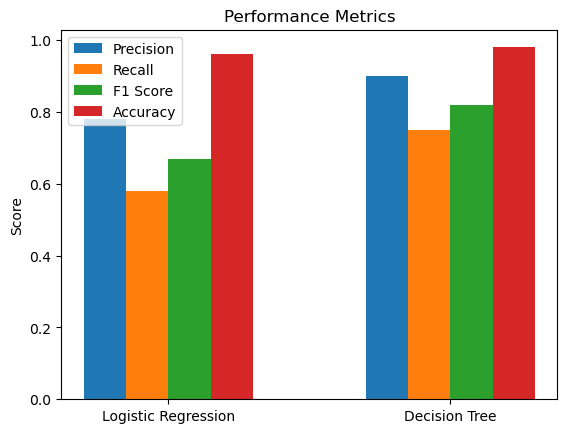

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define the performance metrics
precision = [0.78, 0.90]
recall = [0.58, 0.75]
f1 = [0.67, 0.82]
accuracy = [0.96, 0.98 ]

# Set up the plot
labels = ['Logistic Regression', 'Decision Tree']
x = np.arange(len(labels))
width = 0.15

# Create the bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, precision, width, label='Precision')
rects2 = ax.bar(x - 0.5*width, recall, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, f1, width, label='F1 Score')
rects4 = ax.bar(x + 1.5*width, accuracy, width, label='Accuracy')

# Add some labels and formatting
ax.set_ylabel('Score')
ax.set_title('Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()


In [47]:
# Create a table to display the results
results_table = pd.DataFrame({
    'Model': ['Decision Tree Classifier', 'Logistic Regression'],
    'Mean Accuracy': [np.mean(dtc_scores), np.mean(lr_scores)],
    'Standard Deviation': [np.std(dtc_scores),np.std(lr_scores)]
})

# Display the table
print(results_table)

                      Model  Mean Accuracy  Standard Deviation
0  Decision Tree Classifier       0.938422            0.018312
1       Logistic Regression       0.958595            0.010315


In [55]:
table_data = {'Model': ['Decision Tree', 'Logistic Regression'],
              'Accuracy': [dt_accuracy, lr_accuracy],
              'Precision': [dt_precision, lr_precision],
              'Recall': [dt_recall, lr_recall],
              'F1 Score': [dt_f1,lr_f1]}

table_df = pd.DataFrame(data=table_data)
table_df.set_index('Model', inplace=True)

print(table_df)

                     Accuracy  Precision    Recall  F1 Score
Model                                                       
Decision Tree        0.968254   0.800000  0.666667  0.727273
Logistic Regression  0.962963   0.777778  0.583333  0.666667


In [59]:
table_data = {'Model': ['Decision Tree', 'Logistic Regression'],
              'Accuracy': [d_accuracy, l_accuracy],
              'Precision': [d_precision, l_precision],
              'Recall': [d_recall, l_recall],
              'F1 Score': [d_f1_score,l_f1_score]}

table_df = pd.DataFrame(data=table_data)
table_df.set_index('Model', inplace=True)

print(table_df)

                     Accuracy  Precision    Recall  F1 Score
Model                                                       
Decision Tree        0.968254   0.866525  0.866525  0.866525
Logistic Regression  0.962963   0.875000  0.786017  0.823529


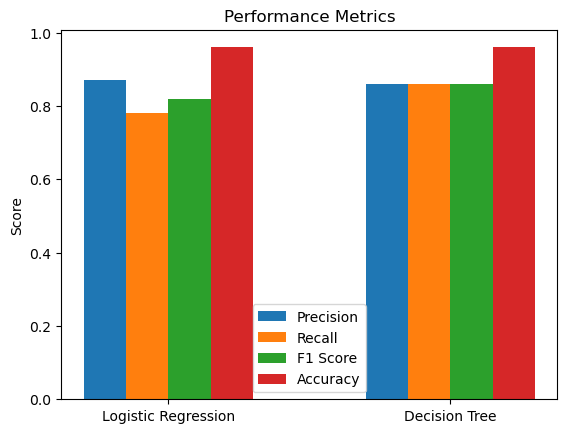

In [60]:

# Define the performance metrics
precision = [0.87, 0.86]
recall = [0.78, 0.86]
f1 = [0.82, 0.86]
accuracy = [0.96, 0.96 ]

# Set up the plot
labels = ['Logistic Regression', 'Decision Tree']
x = np.arange(len(labels))
width = 0.15

# Create the bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, precision, width, label='Precision')
rects2 = ax.bar(x - 0.5*width, recall, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, f1, width, label='F1 Score')
rects4 = ax.bar(x + 1.5*width, accuracy, width, label='Accuracy')

# Add some labels and formatting
ax.set_ylabel('Score')
ax.set_title('Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [ ]:

# Define the performance metrics
precision = [0.78, 0.90]
recall = [0.58, 0.75]
f1 = [0.67, 0.82]
accuracy = [0.96, 0.98 ]

# Set up the plot
labels = ['Logistic Regression', 'Decision Tree']
x = np.arange(len(labels))
width = 0.15

# Create the bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, precision, width, label='Precision')
rects2 = ax.bar(x - 0.5*width, recall, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, f1, width, label='F1 Score')
rects4 = ax.bar(x + 1.5*width, accuracy, width, label='Accuracy')

# Add some labels and formatting
ax.set_ylabel('Score')
ax.set_title('Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()